# Instalando o Kaggle

In [1]:
!pip install kaggle

# Realizando o upload do token de segurança de comunicação com o kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        153           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        290           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        855           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       5194           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      40923           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge      10745           False  
connectx

# Fazendo o download do dataset do kaggle

In [4]:
!kaggle datasets download -d saraivaufc/automatic-weather-stations-brazil

100% 1.39G/1.40G [00:12<00:00, 126MB/s]
100% 1.40G/1.40G [00:12<00:00, 117MB/s]


# Descompactando o dataset baixado

In [5]:
!unzip automatic-weather-stations-brazil.zip

Archive:  automatic-weather-stations-brazil.zip
  inflating: automatic_stations_codes_2000_2021.csv  
  inflating: automatic_weather_stations_inmet_brazil_2000_2021.csv  


# Configurando o Spark

In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

spark

In [8]:
# Criando uma sessão no Spark
spark = SparkSession.builder.getOrCreate()

from datetime import datetime, date  
from pyspark.sql import Row

Carregando dataset no spark

In [9]:
linhas = spark.sparkContext.textFile('automatic_weather_stations_inmet_brazil_2000_2021.csv')

In [10]:
df = linhas.map(lambda line:line.split(';'))

print(df)

#Colunas desejadas
def func(lista):
  return lista[0], lista[1], lista[2], lista[3], lista[4], lista[8], lista[16], lista[19]
 
df_limpo = df.map(func) 

PythonRDD[2] at RDD at PythonRDD.scala:53


In [11]:
df_limpo.take(2)


[('ESTACAO',
  'DATA (YYYY-MM-DD)',
  'HORA (UTC)',
  'PRECIPITACAO TOTAL HORARIO (mm)',
  'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
  'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
  'UMIDADE RELATIVA DO AR, HORARIA (%)',
  'VENTO, VELOCIDADE HORARIA (m/s)'),
 ('A001', '2021-01-01', '0000', '0.0', '887.1', '20.9', '73.0', '0.8')]

In [12]:
#tentar otimizar filtro com isso aqui
filter = ['A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']

In [13]:
df_ceara = df_limpo.filter(lambda x: 'A306' in x or 'A314' in x or 'A315' in x or 'A319' in x or 'A324' in x or 'A325' in x or 'A332' in x or 'A339' in x or 'A342' in x or 'A347' in x or 'A358' in x or 'A359' in x or 'A360' in x or 'A368' in x or 'A369' in x).take(50000)

#df_ceara = df_ceara.map(lambda line:line.split('['))



In [14]:
len(df_ceara)

50000

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType

schema = StructType([
    StructField('ESTACAO', StringType(), True),
    StructField('DATA', DateType(), True),
    StructField('HORA', TimestampType(), True),
    StructField('PRECIPITACAO TOTAL HORARIO (mm)', IntegerType(), True),
    StructField('PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', FloatType(), True),
    StructField('TEMPERATURA DO AR - BULBO SECO, HORARIA (C)', FloatType(), True),
    StructField('UMIDADE RELATIVA DO AR, HORARIA (%)', FloatType(), True),
    StructField('VENTO, VELOCIDADE HORARIA (m/s)', FloatType(), True),
])

# Convert list to RDD
rdd = spark.sparkContext.parallelize(df_ceara)
df = spark.createDataFrame(rdd,['ESTACAO',
  'DATA',
  'HORA',
  'PRECIPITACAO',
  'PRESSAO_ATMOSFERICA',
  'TEMPERATURA',
  'UMIDADE',
  'VENTO'])

# Create data frame
#df = spark.createDataFrame(rdd,schema)
#print(df.schema)
df.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|0000|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01|0100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01|0200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01|0300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01|0400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01|0500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01|0600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01|0700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01|0800|         0.0|             1000.9|       

In [16]:
type(df)

pyspark.sql.dataframe.DataFrame

In [17]:
df.createOrReplaceTempView('tableA')
print(spark.sql('select * from tableA').show())

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|0000|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01|0100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01|0200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01|0300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01|0400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01|0500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01|0600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01|0700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01|0800|         0.0|             1000.9|       

#Tratamento de Dados (ETL)

#### Tratamento de valores misssing/Verificando valores Missing

In [18]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-------+----+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----+----+------------+-------------------+-----------+-------+-----+
|      0|   0|   0|           0|                  0|          0|      0|    0|
+-------+----+----+------------+-------------------+-----------+-------+-----+



Drop e verificação de valores missing se julgado necessário

df.na.drop()

df.describe().show()

In [19]:
df

DataFrame[ESTACAO: string, DATA: string, HORA: string, PRECIPITACAO: string, PRESSAO_ATMOSFERICA: string, TEMPERATURA: string, UMIDADE: string, VENTO: string]

In [20]:
#Convertendo o data Frame
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType, LongType
dfNovo = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(DateType())).withColumn("HORA",df.HORA.cast(IntegerType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(FloatType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(FloatType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(FloatType())).withColumn("UMIDADE",df.UMIDADE.cast(FloatType()))

In [21]:
#dfNovo = dfNovo.withColumn("DATA",df.DATA.cast(LongType()))

In [22]:
dfNovo = dfNovo.withColumn("VENTO", df.VENTO.cast(FloatType()))

In [23]:
dfNovo

DataFrame[ESTACAO: string, DATA: date, HORA: int, PRECIPITACAO: float, PRESSAO_ATMOSFERICA: float, TEMPERATURA: float, UMIDADE: float, VENTO: float]

In [24]:
dfNovo.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01| 800|         0.0|             1000.9|       

# Analise Descritiva dos Dados (Data analysis)

#####Importando Bibliotecas: Data analysis

In [25]:
import numpy as np
import random as rnd
from pyspark.sql.window import Window
import pyspark.sql.functions as F


In [26]:
dfNovo.describe().show()

+-------+-------+-----------------+------------------+-------------------+------------------+-----------------+------------------+
|summary|ESTACAO|             HORA|      PRECIPITACAO|PRESSAO_ATMOSFERICA|       TEMPERATURA|          UMIDADE|             VENTO|
+-------+-------+-----------------+------------------+-------------------+------------------+-----------------+------------------+
|  count|  50000|            50000|             32687|              35269|             35270|            31071|             35253|
|   mean|   null|         1149.872|0.1022791936612944|  976.9155263140663|26.625177200258978| 66.7407228605452|1.8212265609708744|
| stddev|   null|692.2502205296557|1.0429634446217395|   24.1792918717367| 4.001085441031469|19.95580993809345|1.5012775485299408|
|    min|   A306|                0|               0.0|              911.8|              16.0|              7.0|               0.0|
|    max|   A369|             2300|              40.8|             1009.2|         

In [27]:
dfNovo.select('ESTACAO').describe().show()


+-------+-------+
|summary|ESTACAO|
+-------+-------+
|  count|  50000|
|   mean|   null|
| stddev|   null|
|    min|   A306|
|    max|   A369|
+-------+-------+



In [28]:
dfNovo.select('DATA').describe().show()


+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [29]:
dfNovo.select('HORA').describe().show()


+-------+-----------------+
|summary|             HORA|
+-------+-----------------+
|  count|            50000|
|   mean|         1149.872|
| stddev|692.2502205296557|
|    min|                0|
|    max|             2300|
+-------+-----------------+



In [30]:
dfNovo.select('PRECIPITACAO').describe().show()


+-------+------------------+
|summary|      PRECIPITACAO|
+-------+------------------+
|  count|             32687|
|   mean|0.1022791936612944|
| stddev|1.0429634446217395|
|    min|               0.0|
|    max|              40.8|
+-------+------------------+



In [31]:
dfNovo.select('PRESSAO_ATMOSFERICA').describe().show()


+-------+-------------------+
|summary|PRESSAO_ATMOSFERICA|
+-------+-------------------+
|  count|              35269|
|   mean|  976.9155263140663|
| stddev|   24.1792918717367|
|    min|              911.8|
|    max|             1009.2|
+-------+-------------------+



In [32]:
dfNovo.select('TEMPERATURA').describe().show()


+-------+------------------+
|summary|       TEMPERATURA|
+-------+------------------+
|  count|             35270|
|   mean|26.625177200258978|
| stddev| 4.001085441031469|
|    min|              16.0|
|    max|              38.4|
+-------+------------------+



In [33]:
dfNovo.select('UMIDADE').describe().show()


+-------+-----------------+
|summary|          UMIDADE|
+-------+-----------------+
|  count|            31071|
|   mean| 66.7407228605452|
| stddev|19.95580993809345|
|    min|              7.0|
|    max|            100.0|
+-------+-----------------+



In [34]:
dfNovo.select('VENTO').describe().show()

+-------+------------------+
|summary|             VENTO|
+-------+------------------+
|  count|             35253|
|   mean|1.8212265609708744|
| stddev|1.5012775485299408|
|    min|               0.0|
|    max|               9.5|
+-------+------------------+



In [35]:
float(dfNovo.describe("VENTO").filter("summary = 'max'").select("VENTO").collect()[0].asDict()['VENTO'])

9.5

######Percentil dos dados

######Percentis são medidas que dividem a amostra (por ordem crescente dos dados) em 100 partes, cada uma com uma percentagem de dados aproximadamente igual.O k-ésimo percentil Pk é o valor x (xk) que corresponde à frequência cumulativa de N .k/100, onde N é o tamanho amostral. Analise do percentil dos dados para ver o quão proximos estão as camadas de amostras


In [36]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df['ESTACAO'])).alias("percent_rank"))
#df_teste.show()
#df_teste.show(10000)


In [37]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df["DATA"])).alias("percent_rank"))
#df_teste.show(10000)

In [38]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df["HORA"])).alias("percent_rank"))
#df_teste.show(10000)

In [39]:
#Analise pela hora "TEMPERATURA DO AR - BULBO SECO, HORARIA (C)"
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["TEMPERATURA"])).alias("percent_rank"))
#df_teste.show(10000)

In [40]:
#Analise pela hora "UMIDADE RELATIVA DO AR, HORARIA (%)"
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["UMIDADE"])).alias("percent_rank"))
#df_teste.show(10000)

In [41]:
#Analise pela hora Umidade Relativa
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["VENTO"])).alias("percent_rank"))
#df_teste.show(10000)

In [42]:
#Analise pela hora (Atribtuos da amostra)
df_teste = df.select("ESTACAO","DATA","HORA", "PRECIPITACAO", "TEMPERATURA", "PRESSAO_ATMOSFERICA", "TEMPERATURA", "UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["DATA"])).alias("percent_rank"))
df_teste.show(10000)

+-------+----------+----+------------+-----------+-------------------+-----------+-------+-----+--------------------+
|ESTACAO|      DATA|HORA|PRECIPITACAO|TEMPERATURA|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|        percent_rank|
+-------+----------+----+------------+-----------+-------------------+-----------+-------+-----+--------------------+
|   A306|2020-01-01|   0|         0.2|       25.5|             1001.2|       25.5|   77.0|  0.0|                 0.0|
|   A306|2020-01-01| 100|         0.0|       25.1|             1001.6|       25.1|   78.0|  0.0|                 0.0|
|   A306|2020-01-01| 200|         0.0|       25.2|             1001.8|       25.2|   79.0|  0.0|                 0.0|
|   A306|2020-01-01| 300|         0.0|       24.8|             1001.4|       24.8|   80.0|  0.0|                 0.0|
|   A306|2020-01-01| 400|         0.0|       24.6|             1000.6|       24.6|   80.0|  0.0|                 0.0|
|   A306|2020-01-01| 500|         0.2|       24.5|      

# Data Analytics (Vizualição dos Dados)


Conversanto os tipos de dados

In [43]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Plotando gratico dos tipos de dados

In [44]:
dfNovo.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01| 800|         0.0|             1000.9|       

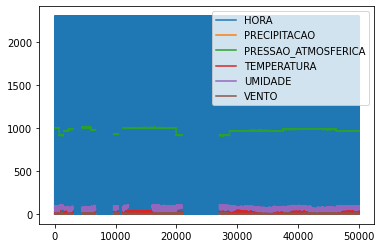

None

In [45]:
df_plots = dfNovo.toPandas()
df_plots.plot()
display(plt.show())

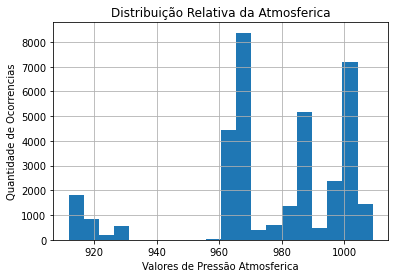

In [46]:
df_plots.PRESSAO_ATMOSFERICA.hist(bins = 20)
plt.xlabel("Valores de Pressão Atmosferica")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Atmosferica")
plt.show()

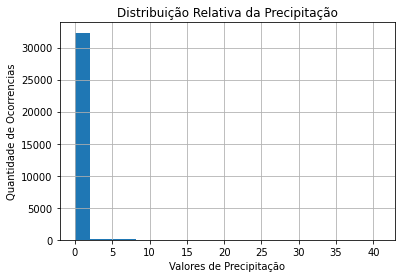

In [47]:
df_plots.PRECIPITACAO.hist(bins = 20)
plt.xlabel("Valores de Precipitação")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Precipitação")
plt.show()
#Concluimos que existe um grande periodo de precipitação no estado do ceara acompanhando de pequenas preciptitações após grande periodo de precipitação

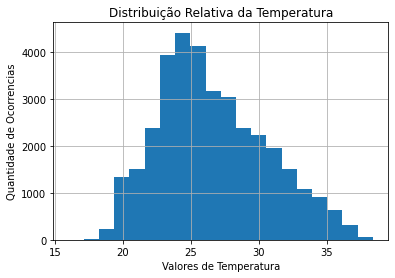

In [48]:
df_plots.TEMPERATURA.hist(bins = 20)
plt.xlabel("Valores de Temperatura")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Temperatura")
plt.show()

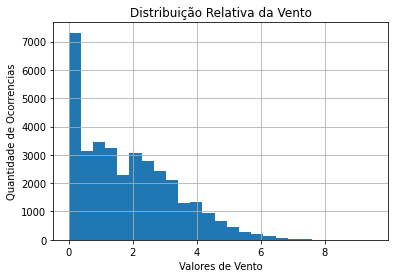

In [49]:
df_plots.VENTO.hist(bins = 25)
plt.xlabel("Valores de Vento")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Vento")
plt.show()

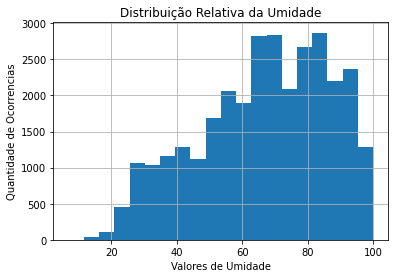

In [50]:
df_plots.UMIDADE.hist(bins = 20)
plt.xlabel("Valores de Umidade")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Umidade")
plt.show()

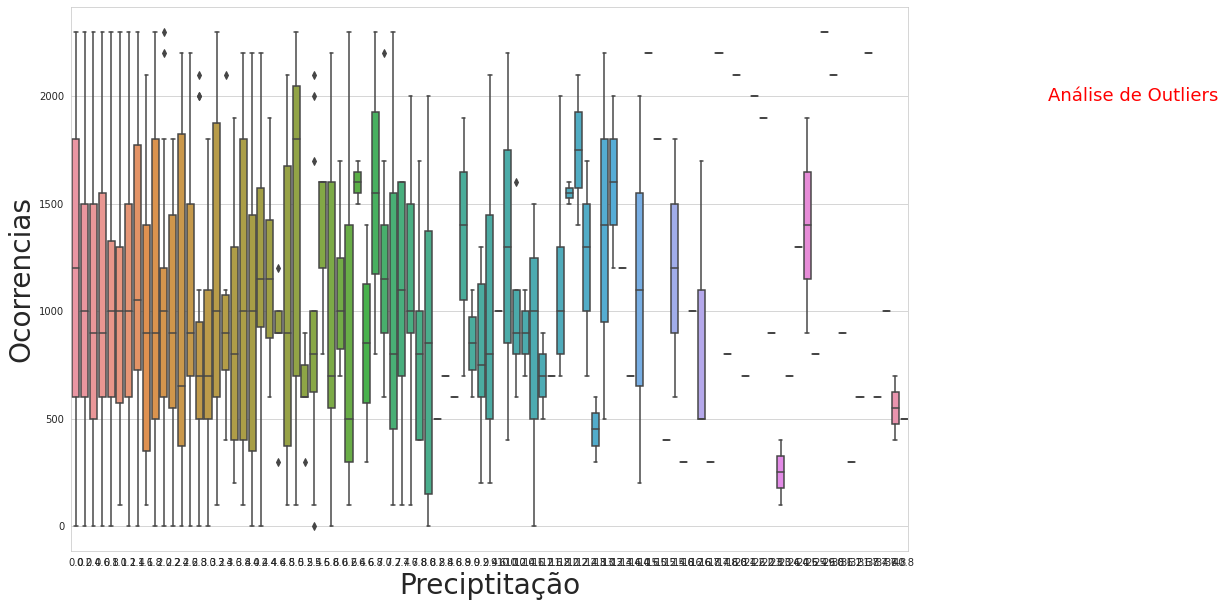

In [51]:
# Crie um Boxplot - Outliers PRECIPITACAO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="PRECIPITACAO", y="HORA", data=df_plots)
ax.text(120.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("Preciptitação",fontdict= {'size':28})
ax.yaxis.set_label_text("Ocorrencias",fontdict= {'size':28})
plt.show()

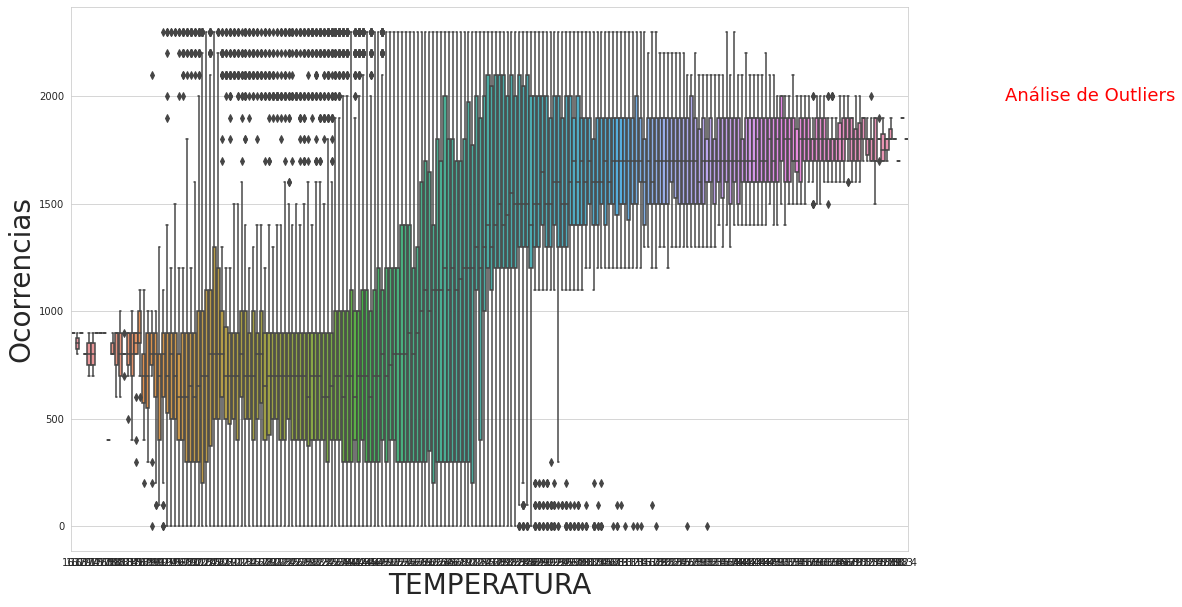

In [52]:
# Crie um Boxplot - Outliers PRECIPITACAO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="TEMPERATURA", y="HORA", data=df_plots)
ax.text(260.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("TEMPERATURA",fontdict= {'size':28})
ax.yaxis.set_label_text("Ocorrencias",fontdict= {'size':28})
plt.show()

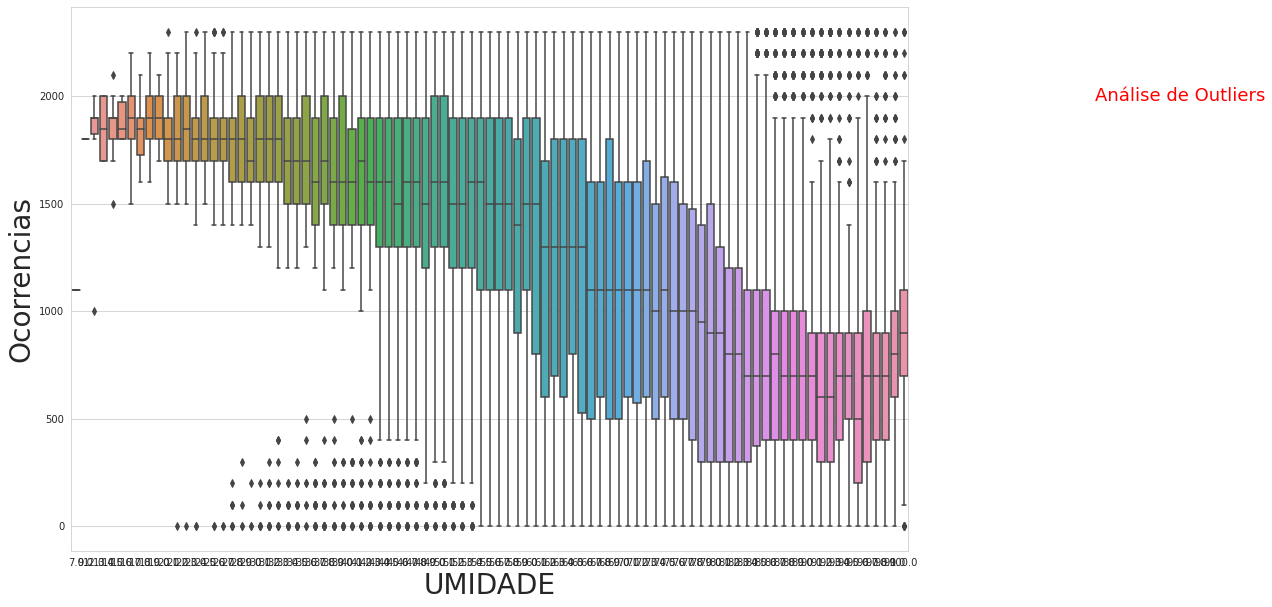

In [53]:
# Crie um Boxplot - Outliers UMIDADE
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="UMIDADE", y="HORA", data=df_plots)
ax.text(120.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("UMIDADE",fontdict= {'size':28})
ax.yaxis.set_label_text("Ocorrencias",fontdict= {'size':28})
plt.show()

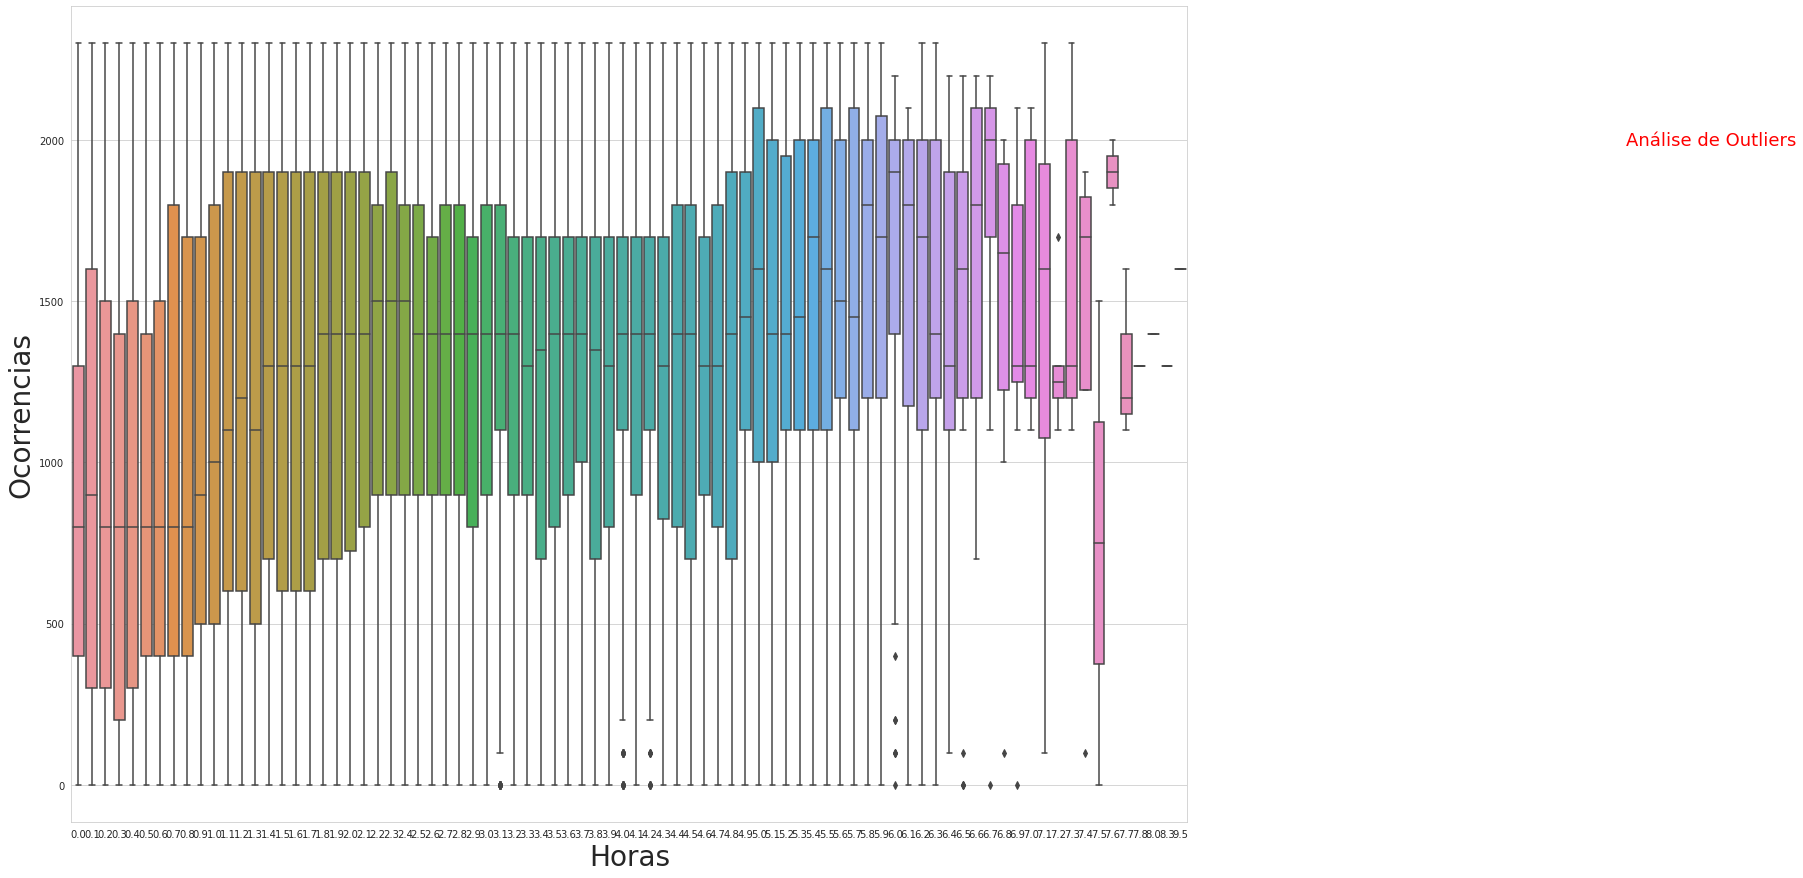

In [54]:
# Crie um Boxplot - Outliers VENTO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,15))
sns.boxplot(x="VENTO", y="HORA", data=df_plots)
ax.text(120.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("Horas",fontdict= {'size':28})
ax.yaxis.set_label_text("Ocorrencias",fontdict= {'size':28})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


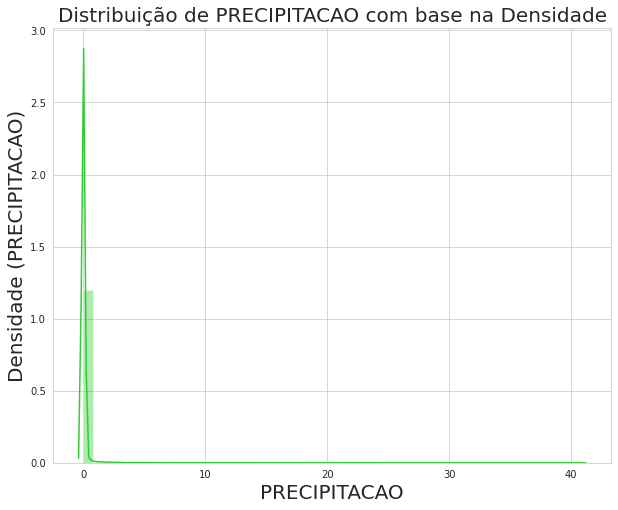

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["PRECIPITACAO"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de PRECIPITACAO com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (PRECIPITACAO)", fontsize= 20)
plt.xlabel("PRECIPITACAO", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


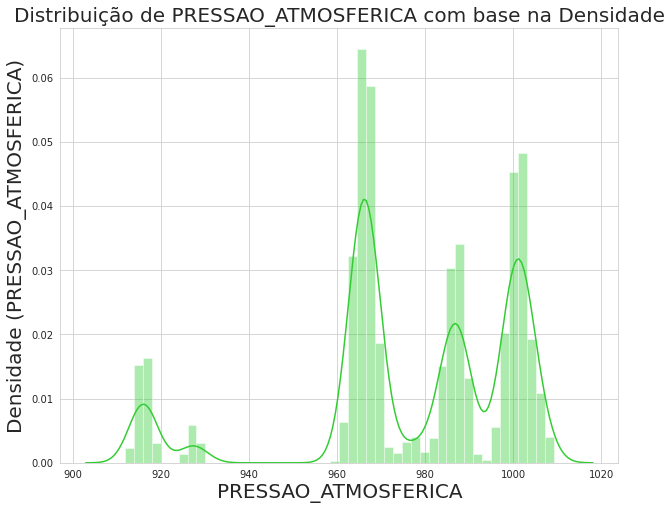

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["PRESSAO_ATMOSFERICA"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de PRESSAO_ATMOSFERICA com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (PRESSAO_ATMOSFERICA)", fontsize= 20)
plt.xlabel("PRESSAO_ATMOSFERICA", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


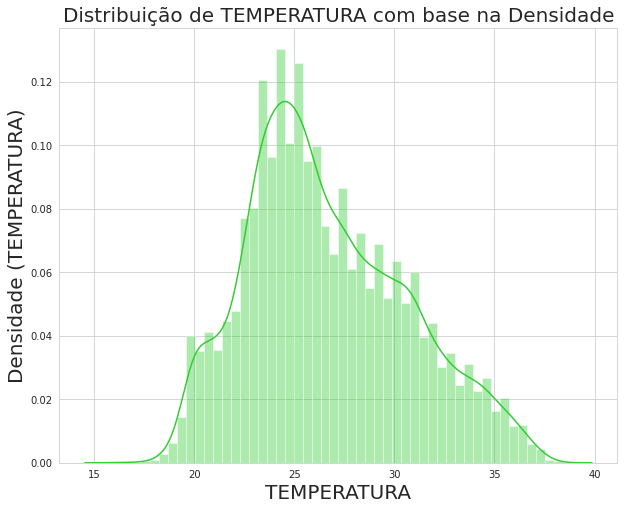

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["TEMPERATURA"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de TEMPERATURA com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (TEMPERATURA)", fontsize= 20)
plt.xlabel("TEMPERATURA", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


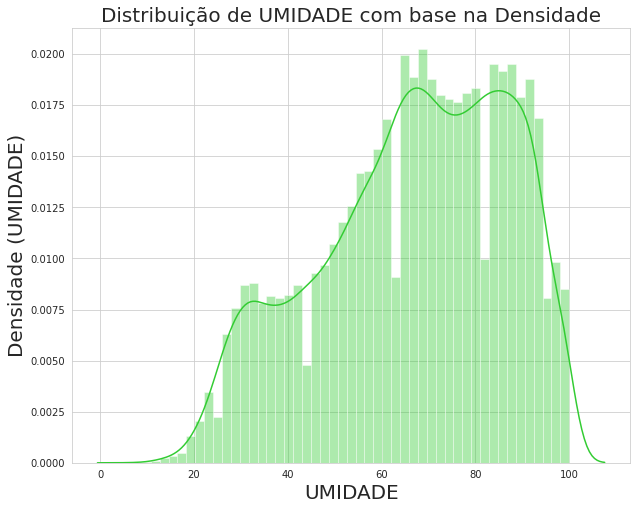

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["UMIDADE"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de UMIDADE com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (UMIDADE)", fontsize= 20)
plt.xlabel("UMIDADE", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


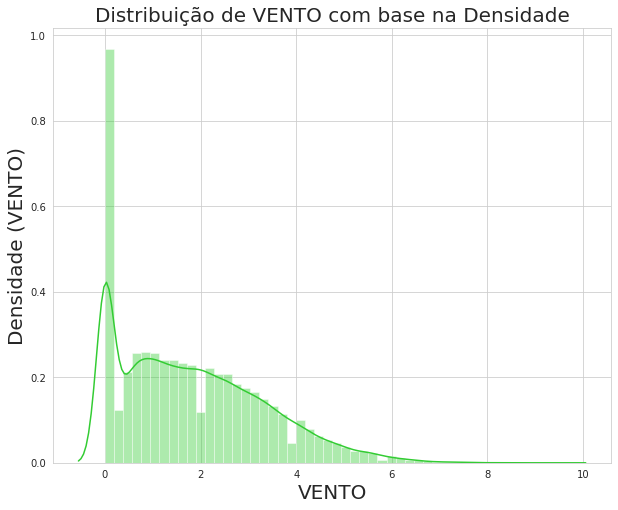

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["VENTO"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de VENTO com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (VENTO)", fontsize= 20)
plt.xlabel("VENTO", fontsize= 20)
plt.show()

In [60]:
def plot_corr(df, size=12):
    corr = df.corr()    
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)  
    plt.xticks(range(len(corr.columns)), corr.columns) 
    plt.yticks(range(len(corr.columns)), corr.columns)

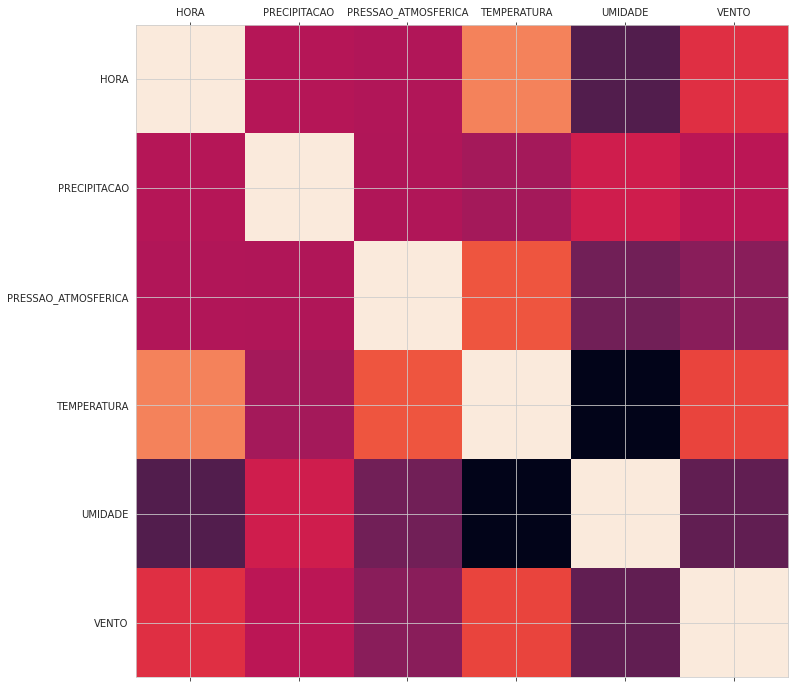

In [61]:
#print do grafico gerado
plot_corr(df_plots)

In [62]:
#Convertendo o data Frame
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType, LongType
dfNovo = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(LongType())).withColumn("HORA",df.HORA.cast(IntegerType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(FloatType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(FloatType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(FloatType())).withColumn("UMIDADE",df.UMIDADE.cast(FloatType())).withColumn("VENTO",df.VENTO.cast(FloatType()))

df_correlacao = dfNovo.drop('ESTACAO')
df_correlacao = df_correlacao.drop('DATA')

df_correlacao.show()
#dfNovo = dfNovo.withColumn("DATA",dfNovo.DATA.cast(LongType()))

+----+------------+-------------------+-----------+-------+-----+
|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+----+------------+-------------------+-----------+-------+-----+
|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
| 800|         0.0|             1000.9|       24.4|   88.0|  0.0|
| 900|         0.0|             1001.5|       24.5|   89.0|  0.0|
|1000|         0.0|             1002.3|       25.2|   87.0|  0.0|
|1100|         0.2|             1002.5|       26.1|   83.0|  0.0|
|1200|    

In [63]:
features = df_correlacao.map(lambda row: row[0:])

from pyspark.mllib.stat import Statistics

corr_mat=Statistics.corr(features, method="pearson")

AttributeError: ignored

In [64]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

vector_col = "coisa"
assembler = VectorAssembler(inputCols=df_correlacao.columns, outputCol=vector_col)
df_vector = assembler.transform(df_correlacao).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

Py4JJavaError: ignored

#Correlação das variaveis

In [ ]:
df_plots.corr()

# Importando bibliotecas de Machine Learning

###### Importando bibliotecas de machine learning: Bibliotecas Sklearn



In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn 
print (sklearn.__version__)
import numpy as np
from sklearn.impute import SimpleImputer

In [ ]:
# Criando objeto para substituição dos valores que faltam pela media, eles serao posterirmente inseridos dessa maneira
# Normalização dados de treino
preenche = SimpleImputer(missing_values = 0, strategy = "mean")

In [ ]:
# Variável a ser prevista Y (Predict Values)
atrib_prev = ['VENTO']

In [ ]:
# Seleção de variáveis preditoras (Feature Selection)
atributos = ['DATA', 'HORA', 'PRECIPITACAO', 'PRESSAO_ATMOSFERICA', 'TEMPERATURA', 'UMIDADE']

In [ ]:
#Criando objetos
#Colunas desejadas 
#X = df.[atributos].values
#Y = df.[atrib_prev].values
X = dfNovo.select(atributos).collect()
Y = dfNovo.select(atrib_prev).collect()

In [ ]:
#Print dos dados dentro armazenados Y
print(X[10:30])
#y.take(100))
#print(Y.collect())

In [ ]:
#Print dos dados dentro armazenados X
print(Y[10:30])
#X.take(100))
#print(X.collect())

Fazendo um split, uma divisão de dados para serem treinados

In [ ]:
#Definindo a taxa de split em 30% e 70% como explicados em sala de aula e debatidos
split_test_size = 0.30

In [ ]:
#Criando um modelo de dados para realizar o treino e de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=101)

#### Apos a separação dos dados de treino e teste para o modelo. 
- Após criar os dados de treino e teste  do modelo

In [ ]:
# Imprimindo os resultados de como os dados serão treinados e testados
#print("{0:0.2f}% nos dados de treino".format((len(X_treino)/len(df.index)) * 100))
#print("{0:0.2f}% nos dados de teste".format((len(X_teste)/len(df.index)) * 100))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Dividindo dados de treino do modelo de arvore de decisão
#X_train, X_test,Y_train, Y_test = traint_test_split(X, Y, teste_size=0.3),random_state=101)

In [ ]:
#Inicializando o modelo de decisão [Arvore de decisão]
dtc = DecisionTreeClassifier()